In [50]:
#import libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import TextVectorization
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras.layers import LayerNormalization,Dense,Embedding,MultiHeadAttention,Dropout,Layer
from tensorflow.keras import Model


In [51]:
import os
import random
from pycocotools.coco import COCO
from PIL import Image

# === Paths ===
data_dir = 'data'
img_dir = os.path.join(data_dir, 'train2017','train2017')
ann_file = os.path.join(data_dir,'annotations_trainval2017', 'annotations', 'captions_train2017.json')

# === Load COCO captions ===
coco = COCO(ann_file)
img_ids = coco.getImgIds()

# === Choose 100 random image IDs ===
selected_img_ids = random.sample(img_ids, 100)

samples = []

for img_id in selected_img_ids:
    img_info = coco.loadImgs(img_id)[0]
    file_name = img_info['file_name']
    file_path = os.path.join(img_dir, file_name)

    # Load the first caption (or more if needed)
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)
    caption = anns[0]['caption'] if anns else ""

    # Load image using PIL (or use tf.io.read_file if you prefer tensors)
    image = Image.open(file_path).convert('RGB')

    samples.append({
        'image': image,
        'caption': caption,
        'file_path': file_path,
    })

# ✅ Now 'samples' is a list of 100 (image, caption) dictionaries


loading annotations into memory...
Done (t=1.00s)
creating index...
index created!


In [52]:
import tensorflow as tf

def load_image_tensor(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

# Convert to tf.data.Dataset if needed
file_paths = [sample['file_path'] for sample in samples]
captions = [sample['caption'] for sample in samples]

dataset = tf.data.Dataset.from_tensor_slices((file_paths, captions))

def process(path, caption):
    image = load_image_tensor(path)
    return {'image': image, 'captions': {'text': caption}}

dataset = dataset.map(process)


In [53]:
#image model (encoder)
encoder = EfficientNetB3(include_top=False,pooling='avg')
encoder.trainable = False
max_token = 10000
max_length = 30
vectorizer = TextVectorization(max_tokens=max_token, output_sequence_length=max_length+1)
captions = dataset.map(lambda x: x['captions']['text'])
vectorizer.adapt(captions)
vocab_size = vectorizer.vocabulary_size()

In [54]:
#feature pre processing

vocab_size

378

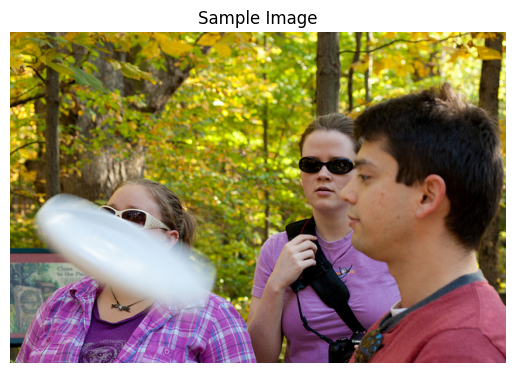

a close up of a person playing with a frisbee near trees


In [55]:
import matplotlib.pyplot as plt
sam = random.choice(samples)

# Display the image
plt.imshow(sam['image'])
plt.axis('off')
plt.title("Sample Image")
plt.show()
print(sam['caption'])


In [56]:
#decoder Layer
class DecoderLayer(Layer):
    def __init__(self,model_dim,self_attention_num,feed_forward_dim,Rate = 0.1):
        super().__init__()
        self.self_attention = MultiHeadAttention(num_heads=self_attention_num,key_dim=model_dim)
        self.cross_attention = MultiHeadAttention(num_heads=self_attention_num,key_dim=model_dim)
        self.feed_forward_nn = tf.keras.Sequential([Dense(feed_forward_dim, activation="relu"), Dense(model_dim)])
        self.norm1 = LayerNormalization()
        self.norm2 = LayerNormalization()
        self.norm3 = LayerNormalization()
        self.drop1 = Dropout(Rate)
        self.drop2 = Dropout(Rate)
        self.drop3 = Dropout(Rate)
        



In [57]:
#decoder
class TransformerDcoder(Layer):
    def __init__(self,model_dim,num_layers,vocabulary_size,positional_encoding_size,feed_forward_dim,self_attention_num,Rate = 0.1):
        super().__init__()
        self.model_dim = model_dim
        self.num_layers = num_layers
        self.embedding = Embedding(vocabulary_size,model_dim)
        self.pos_embedding = Embedding(positional_encoding_size,model_dim)
        self.decoder_layers = [DecoderLayer(model_dim=model_dim,self_attention_num=self_attention_num,Rate=Rate,feed_forward_dim=feed_forward_dim) for _ in range(num_layers)]
        self.dropout = Dropout(Rate)
        
        


In [58]:
#encoder

class ImgEncoder(Layer):
    def __init__(self):
        super().__init__()
        base_model = EfficientNetB3(include_top=False,weights='imagenet')
        base_model.trainable = False

        self.encoder = Model(inputs=base_model.input,outputs=base_model.outputs)


In [59]:
#main model
class MyModel(Model):
    def __init__(self,model_dim,num_layers,vocabulary_size,positional_encoding_size,feed_forward_dim,self_attention_num,Rate):
        super().__init__()
        self.encoder = ImgEncoder()
        self.decoder = TransformerDcoder(model_dim,num_layers,vocabulary_size,positional_encoding_size,feed_forward_dim,self_attention_num,Rate)
        
        
    

In [60]:
# i have mymodel class as my model containing encoder and decoder classes , in encoder class i have efficientnet model without top and in decoder i have a complete decoder of transformer which contains custom decoder layer. 
# as input decoder takes model dimentions , number of layers , vocal size, positional encoding size , feed forward dimention , number of self attention heads and drop out rate.
# to custom decoder it passes model dimention , number of self attention head , feed forward dimention and drop out rate. i want part of code which takes image resize it pass to model which is decleared with hyper parameter and again give back output , also in my file i havent defined logic i just added layer so dont bother about that 


In [61]:
model_dim = 512
num_layers = 4
vocab_size = 10000
pos_encoding_size = 1000
dff = 2048
num_heads = 8
dropout_rate = 0.1


In [62]:
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img)
    img_array = preprocess_input(img_array)  # Match EfficientNet input requirements
    return tf.expand_dims(img_array, axis=0)  # Add batch dimension


In [63]:
model = MyModel(
    model_dim=model_dim,
    num_layers=num_layers,
    vocabulary_size=vocab_size,
    positional_encoding_size=pos_encoding_size,
    feed_forward_dim=dff,
    self_attention_num=num_heads,
    Rate=dropout_rate
)
